<h1>MLP</h1>

In [0]:
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from sklearn.neural_network import MLPClassifier 

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif, RFE, RFECV
from sklearn.metrics import auc, accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

from sklearn import preprocessing

import pickle
from joblib import dump, load


%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

<h2> Understand Data </h2>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#features used to differentiate normal connections from attacks
field_names = pd.read_csv(root_path + "Cyber/Data/Field Names.csv", names=["header", "type"])

added_field_names = pd.DataFrame({"header":["attack", "cnt_correct"],"type":["Nominal", "Count"]})
field_names = field_names.append(added_field_names,sort=False).reset_index().drop("index", axis=1) 

#print data header horizontally for easier viewing
field_names1 = field_names.transpose()
field_names1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
header,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct
type,Numeric,Nominal,Nominal,Nominal,Numeric,Numeric,Binary,Numeric,Numeric,Numeric,Numeric,Binary,Numeric,Binary,Binary,Numeric,Numeric,Numeric,Numeric,Numeric,Binary,Binary,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Numeric,Nominal,Count


In [4]:
#Combine data file "KDDTrain+.txt" and  header file "Field Names.csv"
data = pd.read_csv(root_path + "Cyber/Data/KDDTrain+.txt", names=field_names["header"])
data.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


<h2> Prepare Training and Test Data </h2>

In [0]:
#Training Data#
X_train_raw = data.drop(['attack', 'cnt_correct'], axis=1)
Y_train_raw = data[['attack']]

In [6]:
#X_train_raw.head()
print("Train Set shape", X_train_raw.shape)

Train Set shape (125973, 41)


In [7]:
#X_train_raw.head()
print("Train Set shape", Y_train_raw.shape)

Train Set shape (125973, 1)


In [8]:
# Process Training set and test set, converting normal connection to 0, attack to 1. 
for i, row in Y_train_raw.iterrows():
    #print(row['category'])
    if row['attack'] == 'normal':
        row['attack'] = 0
    else:
        row['attack'] = 1

Y_train_raw.head()

,attack
0,0
1,0
2,1
3,0
4,0


In [9]:
#Process Test Data 
data_test = pd.read_csv(root_path + "Cyber/Data/KDDTest+.txt", names=field_names["header"])

X_test_raw = data_test.drop(['attack', 'cnt_correct'], axis=1)
Y_test_raw = data_test[['attack']]

for i, row in Y_test_raw.iterrows():
    #print(row['category'])
    if row['attack'] == 'normal':
        row['attack'] = 0
    else:
        row['attack'] = 1
        
Y_test_raw.head()

,attack
0,1
1,1
2,0
3,1
4,1


In [10]:
#print the shape of the datasets
print("XTrain Set shape", X_train_raw.shape)
print("YTrain Set shape", Y_train_raw.shape)
print("XTest Set shape", X_test_raw.shape)
print("YTest Set shape", Y_test_raw.shape)

XTrain Set shape (125973, 41)
YTrain Set shape (125973, 1)
XTest Set shape (22544, 41)
YTest Set shape (22544, 1)


<h2> Apply One Hot Encoding </h2>

In [11]:
#print columns with categorical data 
field_names.loc[field_names['type'] =='Nominal'] ##only 3 symbolic protocol type, service, flag

,header,type
1,protocol_type,Nominal
2,service,Nominal
3,flag,Nominal
41,attack,Nominal


In [0]:
cat_columns = ["protocol_type", "service","flag"]

X_train = pd.get_dummies(X_train_raw, prefix_sep="__",
                              columns=cat_columns)

X_test = pd.get_dummies(X_test_raw, prefix_sep="__",
                              columns=cat_columns)

In [13]:
print("XTrain Set shape:", X_train.shape)
print("XTest Set shape:", X_test.shape)

XTrain Set shape: (125973, 122)
XTest Set shape: (22544, 116)


In [0]:
# Get missing columns in the training test
missing_cols = set(X_train.columns ) - set(X_test.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X_test[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
X_test = X_test[X_train.columns]

In [15]:
print("XTrain Set shape:", X_train.shape)
print("XTest Set shape:", X_test.shape)

XTrain Set shape: (125973, 122)
XTest Set shape: (22544, 122)


In [16]:
X_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [17]:
X_test.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [0]:
y_train = Y_train_raw.astype('int')
y_test = Y_test_raw.astype('int')

<h2> Apply MLP Without Data Processing </h2>

In [19]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=200,verbose=2)
mlp.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = inf
Iteration 10, loss = inf
Iteration 11, loss = inf
Iteration 12, loss = inf
Iteration 13, loss = inf
Iteration 14, loss = inf
Iteration 15, loss = inf
Iteration 16, loss = inf
Iteration 17, loss = inf
Iteration 18, loss = inf
Iteration 19, loss = inf
Iteration 20, loss = inf
Iteration 21, loss = inf
Iteration 22, loss = inf
Iteration 23, loss = inf
Iteration 24, loss = inf
Iteration 25, loss = inf
Iteration 26, loss = inf
Iteration 27, loss = inf
Iteration 28, loss = inf
Iteration 29, loss = inf
Iteration 30, loss = inf
Iteration 31, loss = inf
Iteration 32, loss = inf
Iteration 33, loss = inf
Iteration 34, loss = inf
Iteration 35, loss = inf
Iteration 36, loss = inf
Iteration 37, loss = inf
Iteration 38, loss = inf
Iteration 39, loss = inf
Iteration 40, loss = inf
Iteration

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy on training set: 0.951
Accuracy on test set: 0.716


In [0]:
#fit the data
y_pred = mlp.predict(X_test)

In [21]:
#print report
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[9210  501]
 [5896 6937]]
              precision    recall  f1-score   support

           0       0.61      0.95      0.74      9711
           1       0.93      0.54      0.68     12833

    accuracy                           0.72     22544
   macro avg       0.77      0.74      0.71     22544
weighted avg       0.79      0.72      0.71     22544



<h2> Normalization </h2>

In [22]:
X_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [23]:
# Replace the following columns with the log of themselves 
'''If you have variables that always get positive numbers, such as lenght, weight, etc., and that showes 
much more variation with higher values (heteroscedasticity), a log-normal distribution (i.e., normal after 
log-transformation) might be a clearly better description of the data than a normal distribution.
Log-transforming that kind of variables makes the distributions more normally distributed, stabilizes the variances, 
but also makes your model multiplative on the raw scale instead of additive. '''

log_cols = ["duration", "src_bytes", "dst_bytes", "hot", "num_failed_logins", "num_compromised", "num_root", "num_file_creations", 
            "num_shells", "num_access_files"]

dataframe = X_train

for log_col in log_cols:
    if log_col in dataframe.columns:
        print("Processing column: %s" %(log_col))
        dataframe[log_col] = dataframe[log_col].map(lambda x: max(np.log(x), 0))
    else:
        pass

Processing column: duration


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


Processing column: src_bytes
Processing column: dst_bytes
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files


In [24]:
#Normalize columns with numeric data (binary data is not normalized)
numeric_cols = list(field_names["header"][field_names["type"] == "Numeric"])
numeric_cols.remove("num_outbound_cmds")
print(numeric_cols)

['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [25]:
#normalize these columns
X_train_norm = dataframe

norm_type = "mean-std"

for numeric_col in numeric_cols:
    print("Processing column: %s" %(numeric_col))
    tr_values = X_train_norm[numeric_col]
    
    if norm_type == "min-max":
        X_train_norm[numeric_col] = (tr_values - np.min(tr_values))/(np.max(tr_values) - np.min(tr_values))
        X_train_norm[numeric_col] = X_train_norm[numeric_col].astype("float64")
    elif norm_type == "mean-std":
        X_train_norm[numeric_col] = (tr_values - np.min(tr_values))/np.std(tr_values)
        X_train_norm[numeric_col] = X_train_norm[numeric_col].astype("float64")
    else:
        pass

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes
Processing column: wrong_fragment
Processing column: urgent
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files
Processing column: count
Processing column: srv_count
Processing column: serror_rate
Processing column: srv_serror_rate
Processing column: rerror_rate
Processing column: srv_rerror_rate
Processing column: same_srv_rate
Processing column: diff_srv_rate
Processing column: srv_diff_host_rate
Processing column: dst_host_count
Processing column: dst_host_srv_count
Processing column: dst_host_same_srv_rate
Processing column: dst_host_diff_srv_rate
Processing column: dst_host_same_src_port_rate
Processing column: dst_host_srv_diff_host_rate
Processing column: dst_host_serror_rate
Processing column: dst_host_srv_serror_rate
Pro

In [26]:
X_train_norm.head(5)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0.0,2.068858,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.017466,0.027535,0.000000,0.000000,0.0,0.0,2.274686,0.000000,0.000000,1.512008,0.225831,0.378663,0.158796,0.550169,0.000000,0.000000,0.000000,0.163102,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,1.663918,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.113529,0.013767,0.000000,0.000000,0.0,0.0,0.181975,0.831884,0.000000,2.570414,0.009033,0.000000,3.175930,2.847934,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,1.074159,0.082604,2.239873,2.237033,0.0,0.0,0.113734,0.388212,0.000000,2.570414,0.234864,0.222743,0.264661,0.000000,0.000000,2.248291,2.243826,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.0,1.818547,2.537965,0,0.0,0.0,0.0,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.043665,0.068837,0.447975,0.447407,0.0,0.0,2.274686,0.000000,0.000000,0.302402,2.303475,2.227432,0.000000,0.097089,0.355355,0.067449,0.022438,0.000000,0.031303,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,1.767319,1.702167,0,0.0,0.0,0.0,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.261990,0.440556,0.000000,0.000000,0.0,0.0,2.274686,0.000000,0.346381,2.570414,2.303475,2.227432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [27]:
# Replace the following columns with the log of themselves because they have very big range
dataframe_test = X_test

for log_col in log_cols:
    if log_col in dataframe_test.columns:
        print("Processing column: %s" %(log_col))
        dataframe_test[log_col] = dataframe_test[log_col].map(lambda x: max(np.log(x), 0))
    else:
        pass

Processing column: duration
Processing column: src_bytes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Processing column: dst_bytes
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files


In [28]:
#normalize these columns
X_test_norm = dataframe_test

#normalisation
for numeric_col in numeric_cols:
    print("Processing column: %s" %(numeric_col))
    values_test = X_test_norm[numeric_col]
    
    if norm_type == "min-max":
        X_test_norm[numeric_col] = (values_test - np.min(values_test))/(np.max(values_test) - np.min(values_test))
        X_test_norm[numeric_col] = X_test_norm[numeric_col].astype("float64")
    elif norm_type == "mean-std":
        X_test_norm[numeric_col] = (values_test - np.min(values_test))/np.std(values_test)
        X_test_norm[numeric_col] = X_test_norm[numeric_col].astype("float64")
    else:
        pass

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes
Processing column: wrong_fragment
Processing column: urgent
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files
Processing column: count
Processing column: srv_count
Processing column: serror_rate
Processing column: srv_serror_rate
Processing column: rerror_rate
Processing column: srv_rerror_rate
Processing column: same_srv_rate
Processing column: diff_srv_rate
Processing column: srv_diff_host_rate
Processing column: dst_host_count
Processing column: dst_host_srv_count
Processing column: dst_host_same_srv_rate
Processing column: dst_host_diff_srv_rate
Processing column: dst_host_same_src_port_rate
Processing column: dst_host_srv_diff_host_rate
Processing column: dst_host_serror_rate
Processing column: dst_host_srv_serror_rate
Pro

In [29]:
X_test_norm.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type__icmp,protocol_type__tcp,protocol_type__udp,service__IRC,service__X11,service__Z39_50,service__aol,service__auth,service__bgp,service__courier,service__csnet_ns,service__ctf,service__daytime,service__discard,service__domain,service__domain_u,service__echo,service__eco_i,service__ecr_i,service__efs,service__exec,service__finger,service__ftp,service__ftp_data,service__gopher,service__harvest,service__hostnames,service__http,service__http_2784,service__http_443,service__http_8001,service__imap4,service__iso_tsap,service__klogin,service__kshell,service__ldap,service__link,service__login,service__mtp,service__name,service__netbios_dgm,service__netbios_ns,service__netbios_ssn,service__netstat,service__nnsp,service__nntp,service__ntp_u,service__other,service__pm_dump,service__pop_2,service__pop_3,service__printer,service__private,service__red_i,service__remote_job,service__rje,service__shell,service__smtp,service__sql_net,service__ssh,service__sunrpc,service__supdup,service__systat,service__telnet,service__tftp_u,service__tim_i,service__time,service__urh_i,service__urp_i,service__uucp,service__uucp_path,service__vmnet,service__whois,flag__OTH,flag__REJ,flag__RSTO,flag__RSTOS0,flag__RSTR,flag__S0,flag__S1,flag__S2,flag__S3,flag__SF,flag__SH
0,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,1.781597,0.112283,0.0,0.000000,2.40322,2.402658,0.096973,0.231542,0.000000,2.711797,0.089460,0.091811,0.271848,0.000000,0.000000,0.0,0.0,2.582510,2.494599,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,1.058066,0.011228,0.0,0.000000,2.40322,2.402658,0.024243,0.231542,0.000000,2.711797,0.008946,0.000000,0.271848,0.000000,0.000000,0.0,0.0,2.582510,2.494599,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0.358104,2.982939,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.007780,0.011228,0.0,0.000000,0.00000,0.000000,2.424320,0.000000,0.000000,1.425023,0.769358,1.400115,0.181232,1.991762,0.234214,0.0,0.0,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.000000,0.943481,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.007780,0.729840,0.0,0.000000,0.00000,0.000000,2.424320,0.000000,3.944156,0.031903,0.509923,2.295271,0.000000,3.265184,3.278996,0.0,0.0,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.000000,0.000000,0.788089,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0.007780,0.089827,0.0,0.402246,2.40322,1.201329,2.424320,0.000000,2.958117,0.308400,0.769358,0.711534,0.770235,0.097956,0.234214,0.0,0.0,2.143483,1.771165,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [30]:
print("XTrain Set shape:",X_train_norm.shape)
print("XTest Set shape:", X_test_norm.shape)

XTrain Set shape: (125973, 122)
XTest Set shape: (22544, 122)


<h2> Apply MLP After Data Normalisation </h2>

In [31]:
mlp_norm = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=200,verbose=2)
mlp_norm.fit(X_train_norm, y_train)
print("Accuracy on normalized training set: {:.3f}".format(mlp_norm.score(X_train_norm, y_train)))
print("Accuracy on normalized test set: {:.3f}".format(mlp_norm.score(X_test_norm, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.15293626
Iteration 2, loss = 0.04186121
Iteration 3, loss = 0.02918035
Iteration 4, loss = 0.02379242
Iteration 5, loss = 0.02042819
Iteration 6, loss = 0.01824462
Iteration 7, loss = 0.01688682
Iteration 8, loss = 0.01586329
Iteration 9, loss = 0.01486600
Iteration 10, loss = 0.01396252
Iteration 11, loss = 0.01328708
Iteration 12, loss = 0.01244204
Iteration 13, loss = 0.01155278
Iteration 14, loss = 0.01090716
Iteration 15, loss = 0.01082620
Iteration 16, loss = 0.01015113
Iteration 17, loss = 0.00976735
Iteration 18, loss = 0.00924614
Iteration 19, loss = 0.00906017
Iteration 20, loss = 0.00899004
Iteration 21, loss = 0.00852840
Iteration 22, loss = 0.00837566
Iteration 23, loss = 0.00809129
Iteration 24, loss = 0.00805303
Iteration 25, loss = 0.00784523
Iteration 26, loss = 0.00772756
Iteration 27, loss = 0.00756422
Iteration 28, loss = 0.00717471
Iteration 29, loss = 0.00718491
Iteration 30, loss = 0.00700005
Iteration 31, loss = 0.00705666
Iteration 32, los

In [0]:
#fit the data
y_pred_norm = mlp_norm.predict(X_test_norm)

In [33]:
#print report
print(confusion_matrix(y_test, y_pred_norm))  
print(classification_report(y_test, y_pred_norm))

[[9049  662]
 [3633 9200]]
              precision    recall  f1-score   support

           0       0.71      0.93      0.81      9711
           1       0.93      0.72      0.81     12833

    accuracy                           0.81     22544
   macro avg       0.82      0.82      0.81     22544
weighted avg       0.84      0.81      0.81     22544



<h2> Apply Variance Thresholding </h2>

In [0]:
# Create VarianceThreshold object with a variance with a threshold of 0.5
thresholder = VarianceThreshold(threshold=.90)

# Conduct variance thresholding
X_train_var = thresholder.fit_transform(X_train_norm)
X_test_var = thresholder.fit_transform(X_test_norm)

In [35]:
print("XTrain Set shape:",X_train_var.shape)
print("XTest Set shape:", X_test_var.shape)

XTrain Set shape: (125973, 31)
XTest Set shape: (22544, 31)


<h2> Apply MLP After Variance Thresholding </h2>

In [36]:
mlp_var = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=200,verbose=2)
mlp_var.fit(X_train_var, y_train)
print("Accuracy on normalized training set: {:.3f}".format(mlp_var.score(X_train_var, y_train)))
print("Accuracy on normalized test set: {:.3f}".format(mlp_var.score(X_test_var, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.17552779
Iteration 2, loss = 0.05726144
Iteration 3, loss = 0.04825501
Iteration 4, loss = 0.04274388
Iteration 5, loss = 0.03851850
Iteration 6, loss = 0.03525113
Iteration 7, loss = 0.03234575
Iteration 8, loss = 0.03038814
Iteration 9, loss = 0.02860200
Iteration 10, loss = 0.02683801
Iteration 11, loss = 0.02566598
Iteration 12, loss = 0.02412490
Iteration 13, loss = 0.02333716
Iteration 14, loss = 0.02239949
Iteration 15, loss = 0.02178469
Iteration 16, loss = 0.02125165
Iteration 17, loss = 0.02040799
Iteration 18, loss = 0.01991814
Iteration 19, loss = 0.01969129
Iteration 20, loss = 0.01933179
Iteration 21, loss = 0.01882181
Iteration 22, loss = 0.01879989
Iteration 23, loss = 0.01826423
Iteration 24, loss = 0.01822216
Iteration 25, loss = 0.01783773
Iteration 26, loss = 0.01765328
Iteration 27, loss = 0.01732384
Iteration 28, loss = 0.01745165
Iteration 29, loss = 0.01697905
Iteration 30, loss = 0.01698009
Iteration 31, loss = 0.01725272
Iteration 32, los

In [0]:
#fit the data
y_pred_var = mlp_var.predict(X_test_var)

In [38]:
#print report
print(confusion_matrix(y_test, y_pred_var))  
print(classification_report(y_test, y_pred_var))

[[9429  282]
 [4832 8001]]
              precision    recall  f1-score   support

           0       0.66      0.97      0.79      9711
           1       0.97      0.62      0.76     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.80      0.77     22544
weighted avg       0.83      0.77      0.77     22544



<h2> Apply F-Test </h2>

In [0]:
#Set how floating-point errors are handled.
np.seterr(divide='ignore', invalid='ignore');

In [40]:
selector = SelectPercentile(f_classif, percentile=10)
selector = selector.fit(X_train_norm, y_train.values.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [16] are constant.
  UserWarning)


In [41]:
X_train_f = list(X_train_norm.columns[selector.get_support(indices=True)])
X_train_f 

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'flag__S0',
 'flag__SF']

<h2> Apply MLP After F-test </h2>

In [42]:
mlp_f = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=200,verbose=2)
mlp_f.fit(X_train_norm[X_train_f], y_train)
print("Accuracy on normalized training set: {:.3f}".format(mlp_f.score(X_train_norm[X_train_f], y_train)))
print("Accuracy on normalized test set: {:.3f}".format(mlp_f.score(X_test_norm[X_train_f], y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.21811553
Iteration 2, loss = 0.09501380
Iteration 3, loss = 0.07899119
Iteration 4, loss = 0.07286380
Iteration 5, loss = 0.06885153
Iteration 6, loss = 0.06623516
Iteration 7, loss = 0.06401647
Iteration 8, loss = 0.06175946
Iteration 9, loss = 0.05994316
Iteration 10, loss = 0.05798025
Iteration 11, loss = 0.05623433
Iteration 12, loss = 0.05453142
Iteration 13, loss = 0.05257839
Iteration 14, loss = 0.05108356
Iteration 15, loss = 0.04958980
Iteration 16, loss = 0.04838905
Iteration 17, loss = 0.04726653
Iteration 18, loss = 0.04632344
Iteration 19, loss = 0.04551476
Iteration 20, loss = 0.04468726
Iteration 21, loss = 0.04401059
Iteration 22, loss = 0.04330759
Iteration 23, loss = 0.04269089
Iteration 24, loss = 0.04219751
Iteration 25, loss = 0.04153716
Iteration 26, loss = 0.04101755
Iteration 27, loss = 0.04070793
Iteration 28, loss = 0.04025676
Iteration 29, loss = 0.04002083
Iteration 30, loss = 0.03948229
Iteration 31, loss = 0.03895220
Iteration 32, los

In [0]:
#fit the data
y_pred_f = mlp_f.predict(X_test_norm[X_train_f])

In [44]:
#print report
print(confusion_matrix(y_test, y_pred_f))  
print(classification_report(y_test, y_pred_f))

[[9365  346]
 [4095 8738]]
              precision    recall  f1-score   support

           0       0.70      0.96      0.81      9711
           1       0.96      0.68      0.80     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544



<h2> Apply MLP with PCA </h2>

<p>scikit-learn choose the minimum number of principal components such that 95% of the variance is retained</p>

In [0]:
pca = PCA(.95)

In [0]:
pca.fit(X_train_norm)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [47]:
mlp_pca = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=200,verbose=2)
mlp_pca.fit(X_train_pca, y_train)
print("Accuracy on training set: {:.3f}".format(mlp_pca.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp_pca.score(X_test_pca, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.17774803
Iteration 2, loss = 0.06252723
Iteration 3, loss = 0.05030960
Iteration 4, loss = 0.04415078
Iteration 5, loss = 0.03936339
Iteration 6, loss = 0.03730792
Iteration 7, loss = 0.03507472
Iteration 8, loss = 0.03381443
Iteration 9, loss = inf
Iteration 10, loss = 0.03144751
Iteration 11, loss = 0.03039875
Iteration 12, loss = 0.02982796
Iteration 13, loss = 0.02903371
Iteration 14, loss = 0.02833921
Iteration 15, loss = 0.02800839
Iteration 16, loss = 0.02728288
Iteration 17, loss = 0.02687978
Iteration 18, loss = 0.02676394
Iteration 19, loss = 0.02618912
Iteration 20, loss = 0.02607028
Iteration 21, loss = 0.02570464
Iteration 22, loss = 0.02570617
Iteration 23, loss = 0.02482171
Iteration 24, loss = 0.02523196
Iteration 25, loss = 0.02437636
Iteration 26, loss = 0.02469997
Iteration 27, loss = 0.02411539
Iteration 28, loss = 0.02401130
Iteration 29, loss = 0.02423717
Iteration 30, loss = 0.02366698
Iteration 31, loss = 0.02351081
Iteration 32, loss = 0.0

In [0]:
#predict the data
y_pred_pca = mlp_pca.predict(X_test_pca)

In [49]:
#print report
print(confusion_matrix(y_test, y_pred_pca))  
print(classification_report(y_test, y_pred_pca))

[[9436  275]
 [4494 8339]]
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      9711
           1       0.97      0.65      0.78     12833

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



<h2> Feature Selection and Elimination </h2>



<p> Variance Thresholding, F-test and PCA have been applied. F-test improved the accuracy significantly. <p>

---



<h2> Hyperparameter Tuning</h2>

In [0]:
parameter_space = {
    'hidden_layer_sizes': [(10,10,10),(50,50,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
    

In [51]:
mlp_clf = RandomizedSearchCV(MLPClassifier(max_iter=200), parameter_space, n_jobs=-1, cv=3)
mlp_clf.fit(X_train_var, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           rand...
                                           validation_fraction=0.1,
                                           verbose=False, warm_start=False),
                   iid='warn', n_it

In [53]:
# Best paramete set
print('Best parameters found:\n', mlp_clf.best_params_)

# All results
means = mlp_clf.cv_results_['mean_test_score']
stds = mlp_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mlp_clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'tanh'}
0.996 (+/-0.000) for {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'relu'}
0.997 (+/-0.001) for {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'relu'}
0.995 (+/-0.001) for {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10, 10, 10), 'alpha': 0.05, 'activation': 'tanh'}
0.994 (+/-0.001) for {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10, 10, 10), 'alpha': 0.0001, 'activation': 'tanh'}
0.996 (+/-0.001) for {'solver': 'sgd', 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 50, 50), 'alpha': 0.0001, 'activation': 'tanh'}
0.995 (+/-0.002) for {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10, 10, 10), 'alpha': 0.0001, 'activation': 't

In [55]:
mlp_search = MLPClassifier(max_iter=200,solver='adam',learning_rate='constant',
                                 hidden_layer_sizes=(50, 50, 50),alpha=0.0001,activation='tanh')

mlp_search.fit(X_train_var, y_train.values.ravel())

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
y_pred_clf = mlp_search.predict(X_test_var)

In [60]:
#print report
print(confusion_matrix(y_test, y_pred_clf))  
print(classification_report(y_test, y_pred_clf))

[[9421  290]
 [4278 8555]]
              precision    recall  f1-score   support

           0       0.69      0.97      0.80      9711
           1       0.97      0.67      0.79     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544



<h2> Plot ROC Curve </h2>

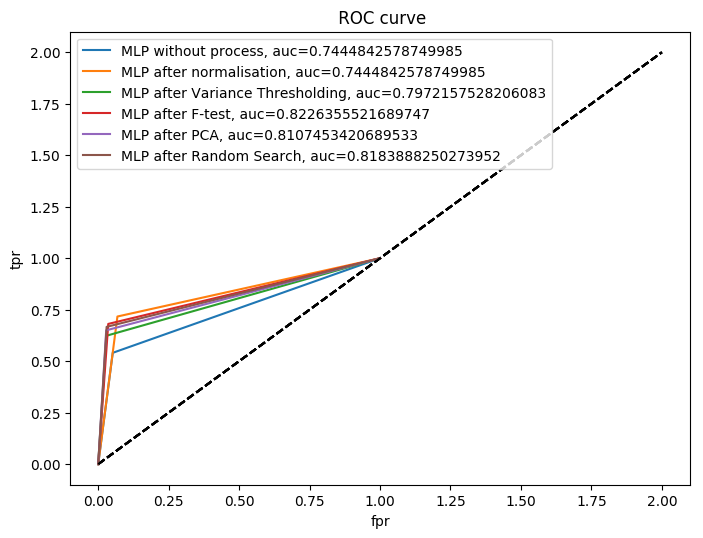

In [67]:
from sklearn import metrics
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test,  y_pred)
auc1 = metrics.roc_auc_score(y_test, y_pred)
plt.plot(fpr1,tpr1,label="MLP without process, auc="+str(auc1))
plt.plot([0,2],[0,2],'k--')

fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test,  y_pred_norm)
auc2 = metrics.roc_auc_score(y_test, y_pred_norm)
plt.plot(fpr2,tpr2,label="MLP after normalisation, auc="+str(auc1))
plt.plot([0,2],[0,2],'k--')

fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test,y_pred_var)
auc3 = metrics.roc_auc_score(y_test, y_pred_var)
plt.plot(fpr3,tpr3,label="MLP after Variance Thresholding, auc="+str(auc3))
plt.plot([0,2],[0,2],'k--')

fpr4, tpr4, thresholds4 = metrics.roc_curve(y_test,  y_pred_f)
auc4 = metrics.roc_auc_score(y_test, y_pred_f)
plt.plot(fpr4,tpr4,label="MLP after F-test, auc="+str(auc4))
plt.plot([0,2],[0,2],'k--')

fpr6, tpr6, thresholds6 = metrics.roc_curve(y_test,  y_pred_pca)
auc6 = metrics.roc_auc_score(y_test, y_pred_pca)
plt.plot(fpr6,tpr6,label="MLP after PCA, auc="+str(auc6))
plt.plot([0,2],[0,2],'k--')

fpr7, tpr7, thresholds7 = metrics.roc_curve(y_test,  y_pred_clf)
auc7 = metrics.roc_auc_score(y_test, y_pred_clf)
plt.plot(fpr7,tpr7,label="MLP after Random Search, auc="+str(auc7))
plt.plot([0,2],[0,2],'k--')

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title(' ROC curve')

plt.legend(loc=2)
plt.show()